# 自定义并训练一个神经网络

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [12]:
transforms.Compose?

转换一下数据集的格式，归一化为范围[-1, 1]的Tensor

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

查看数据集的存储内容

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data = unpickle('./data/cifar-10-batches-py/data_batch_1')

In [4]:
data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [5]:
data[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [6]:
data[b'data'].shape

(10000, 3072)

查看类别代表的真正名称

In [7]:
names = unpickle('./data/cifar-10-batches-py/batches.meta')
names

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [8]:
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
test = iter(trainloader)

In [10]:
i, j = test.next()

In [11]:
i.size(), j.size()

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

展示训练图像

truck truck horse airplane


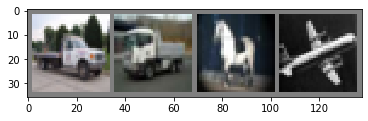

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()  # 一个images中存储了4张图片的信息

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

定义卷积神经网络

In [13]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 输入为3通道图像

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, self.num_flat_features(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()

定义loss函数和优化器

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

训练网络

In [15]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.198
[1,  4000] loss: 1.932
[1,  6000] loss: 1.728
[1,  8000] loss: 1.599
[1, 10000] loss: 1.542
[1, 12000] loss: 1.484
[2,  2000] loss: 1.424
[2,  4000] loss: 1.426
[2,  6000] loss: 1.388
[2,  8000] loss: 1.357
[2, 10000] loss: 1.347
[2, 12000] loss: 1.324
Finished Training


利用测试数据对学习到东西进行查看

GroundTruth:    cat  ship  ship airplane


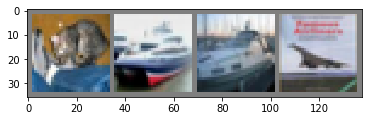

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
outputs = net(Variable(images))

In [21]:
outputs.data

tensor([[ 0.3995, -1.1990,  0.2702,  2.4839,  0.8131,  1.8707, -0.7215,  1.1497,
         -1.1493, -1.6273],
        [ 3.6463,  6.8161, -1.6644, -2.1013, -2.6427, -3.4814, -3.3838, -2.7610,
          6.1966,  3.8016],
        [ 2.2786,  4.4152, -1.1852, -1.2119, -1.9242, -2.1236, -1.4969, -2.5410,
          4.9610,  2.3929],
        [ 3.0676,  0.4326,  0.6879, -0.8984,  0.2345, -2.1799, -1.6728, -1.2479,
          3.5073, -0.0793]])

In [23]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()]
                              for j in range(4)))

Predicted:    cat automobile  ship  ship


查看网络在验证集上的表现

In [24]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


查看各个类别的表现

In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 41 %
Accuracy of automobile : 62 %
Accuracy of  bird : 34 %
Accuracy of   cat : 32 %
Accuracy of  deer : 48 %
Accuracy of   dog : 49 %
Accuracy of  frog : 42 %
Accuracy of horse : 70 %
Accuracy of  ship : 81 %
Accuracy of truck : 61 %


In [32]:
(predicted == labels).size()

torch.Size([4])

In [34]:
(predicted == labels).squeeze()[0]

tensor(False)

In [35]:
torch.__version__
torchvision.datasets.ImageFolder

'1.5.0'